# Notebook Actividad_4_clasificacion_multiclase_diamonds con el objetivo de practicar la manera normal de hacer modelos con scikit-learn y tensorflow.
(ya aprendí a hacer notebooks ^_^)

## Aquí primero importamos todo lo necesario para realizar la práctica

In [49]:
#imports necesarios para las primeras partes
import pandas as pd           
import numpy as np         
import matplotlib.pyplot as plt 
import seaborn as sns         
import tensorflow as tf    

#Imports necesarios para la parte de tensorflow y scikit-learn
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.utils import to_categorical  
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Se cargan los datos y se hace un muestreo de las 5 primeras filas

In [50]:
#permite cargar las datos, gráficos, etc, dentro del propio notebook
%matplotlib inline

#Cargamos el dataset de diamantes
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/diamonds.csv"
df = pd.read_csv(url)

#Mostramos las primeras filas del dataset
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Comprobamos y limpiamos los datos

In [51]:
#no añado a mano nulos o duplicados, pero lo compruebo por si fuera el caso

#compruebo si hay valores nulos 
print("Valores nulos por columna:")
print(df.isnull().sum())

if df.isnull().values.any():
    print("Existen nulos")
    df = df.dropna() #elimino los nulos
else:
    print("No existen nulos")

#compruebo si hay valores duplicados
num_dup = df.duplicated().sum()
if num_dup > 0:
    print("Existen duplicados")
    df = df.drop_duplicates() #elimino los duplicados, especificamente las que sean todos los datos de toas las columnas, si no, se puede especificar con subset
else:
    print("No existen duplicados")

#compruebo si hay errores en datos concretos
col_tresdimensiones = ['x', 'y', 'z']
for col in col_tresdimensiones:
    if(df[col] <= 0).any():
        print("Error en ", col)
        df = df[df[col] > 0] #en vez de eliminar, solo me quedo con las que sean mayores que 0, ya que al ser dimensiones, no pueden ser negativas
    else:
        print("No hay errores en ", col)


#y se muestra info del dataset limpio
print("\n Info del dataset limpio:")
print(df.info())


Valores nulos por columna:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
No existen nulos
Existen duplicados
Error en  x
No hay errores en  y
Error en  z

 Info del dataset limpio:
<class 'pandas.core.frame.DataFrame'>
Index: 53775 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53775 non-null  float64
 1   cut      53775 non-null  object 
 2   color    53775 non-null  object 
 3   clarity  53775 non-null  object 
 4   depth    53775 non-null  float64
 5   table    53775 non-null  float64
 6   price    53775 non-null  int64  
 7   x        53775 non-null  float64
 8   y        53775 non-null  float64
 9   z        53775 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB
None


## Ahora se realizan los EDA, un univariante, un bivariante y un multivariante

Univariante - un gráfico de barras de cut

C:\Users\ismae\AppData\Local\Temp\ipykernel_21612\4172671601.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df['cut'], palette='rocket')


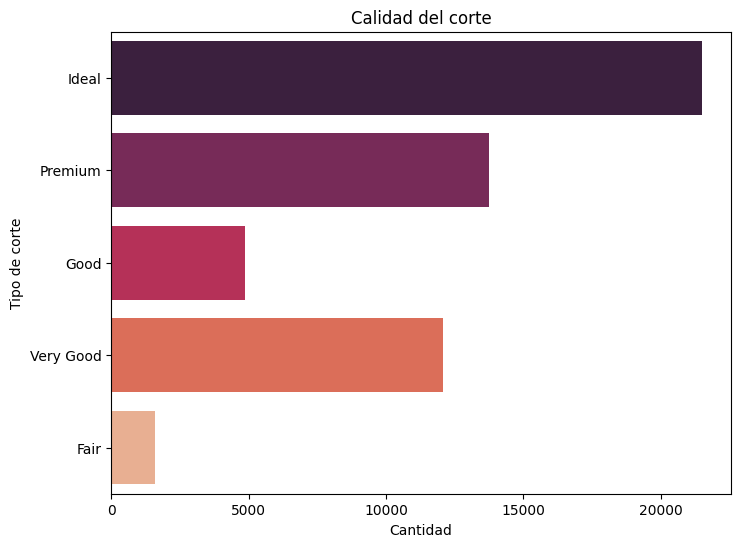

In [52]:
plt.figure(figsize=(8,6))
sns.countplot(df['cut'], palette='rocket')
plt.title('Calidad del corte')
plt.ylabel('Tipo de corte')
plt.xlabel('Cantidad')
plt.show()

Bivariante - comparación entre carat y price, separando por cut

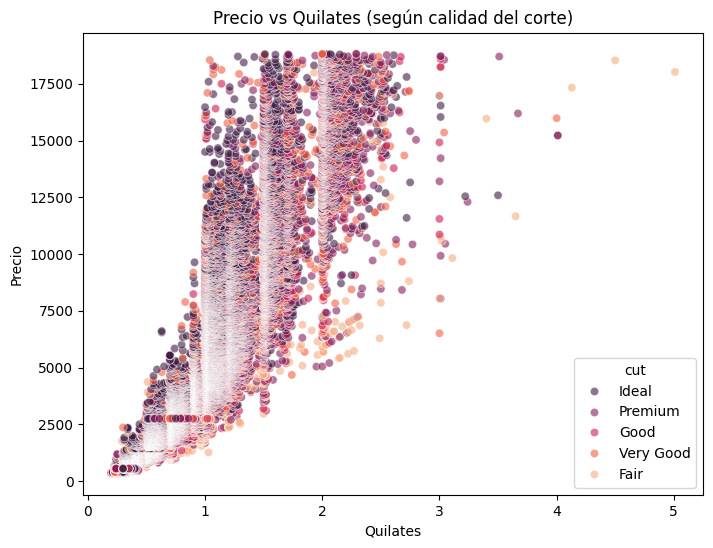

In [53]:
plt.figure(figsize=(8,6))
sns.scatterplot( data=df, x='carat', y='price', hue='cut', palette='rocket', alpha=0.6)
plt.title('Precio vs Quilates (según calidad del corte)')
plt.ylabel('Precio')
plt.xlabel('Quilates')
plt.show()

Multivariante - volumen del diamante con heatmap

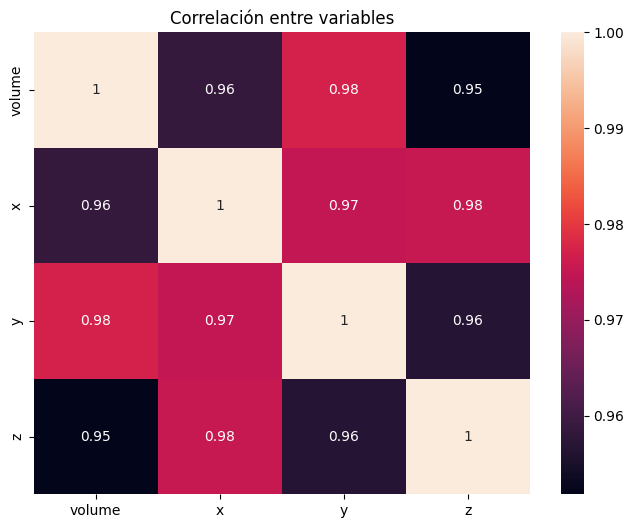

In [54]:
df['volume'] = df['x']*df['y']*df['z'] #con la multiplicación de las 3 dimensiones
col_volumen = ['volume', 'x', 'y', 'z']
corr_volumen = df[col_volumen].corr()
#hago la correlación entre las 3 dimensiones y el volumen antes, ya que si se hace dentro del heatmap, salta error porque pilla columnas con strings, y no floats

plt.figure(figsize=(8,6))
sns.heatmap(corr_volumen, annot=True, cmap='rocket')
plt.title('Correlación entre variables')
plt.show()


## Ahora se hace el preprocesado, es decir se preparan los datos para el modelado

In [55]:
#convierto todo cut en números
le = LabelEncoder()
df['cut_encoded'] = le.fit_transform(df['cut'])

#encodeo las variables categóricas como color y claridad meidante one-hot encoding, para pasarlas a binario
df = pd.get_dummies(df, columns=['color', 'clarity'], drop_first=True)

#ahora se comprueban las 5 primeras filas para ver si se aplicaron bien los cambios
df.head()


,carat,cut,depth,table,price,x,y,z,volume,cut_encoded,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,38.202030,2,...,False,False,False,False,False,True,False,False,False,False
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,34.505856,3,...,False,False,False,False,True,False,False,False,False,False
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,38.076885,1,...,False,False,False,False,False,False,True,False,False,False
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,46.724580,3,...,False,True,False,False,False,False,False,True,False,False
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,51.917250,1,...,False,False,True,False,False,True,False,False,False,False


Ahora se separan cut y cut_encoded, se elimina cut, y se añade la nueva columna encodeada

In [56]:
X = df.drop(columns=['cut', 'cut_encoded'])
y = df['cut_encoded']

Después se sigue con el escalado con StandardScaler para la normalización de las variables, es decir, que todas las var numéricas, tengan el mismo peso en el modelado

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Forma de X_scaled:", X_scaled.shape)
print("Forma de y:", y.shape)

Forma de X_scaled: (53775, 21)
Forma de y: (53775,)


Una vez hecho esto, se hace el split entre entrenamiento y test (20%)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=11, stratify=y)

print("entrenamiento:", X_train.shape[0])
print("test:", X_test.shape[0])

entrenamiento: 43020
test: 10755


## Por último, se hacen los modelados con scikit-learn y tensorflow

**Random Forest con Scikit-Learn**

In [61]:
clf = RandomForestClassifier(random_state=11)

#entreno el modelo con los datos de entrenamiento
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#ahora muestro la evaluacion
print("Precisión:", accuracy_score(y_test, y_pred))
print("\n Clasificación:")
print(classification_report(y_test, y_pred))

Precisión: 0.7745234774523477

 Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       319
           1       0.76      0.69      0.72       978
           2       0.83      0.92      0.87      4297
           3       0.75      0.82      0.78      2747
           4       0.67      0.50      0.57      2414

    accuracy                           0.77     10755
   macro avg       0.78      0.75      0.76     10755
weighted avg       0.77      0.77      0.77     10755



El modelo tiene un 77.45% de precisión, y por clase se puede ver que varía. La clase 0 muestra un buen f1-score (media entre precision y recall), pero la clase 4 tiene uno algo bajo

**Tensorflow con Keras**

In [62]:
#se pasan las etiquetas y_train y y_test, que son enteros, mediante to_categorical a vectores one-hot, para que la red neuronal pueda trabajar con ellos
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

#ahora se define el modelo de la red neuronal
model = Sequential([
    #capa densa de 64 neuronas con activación relu, y como input_shape la forma de X_train, vamos, el número de características
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    #dropout del 20% para evitar sobreajuste
    Dropout(0.2),
    #segundd capa densa de 32 neuronas con activación relu
    Dense(32, activation='relu'),
    #dropout del 20% para evitar sobreajuste
    Dropout(0.2),
    #capa de salida con activación softmax, con tantas neuronas como clases haya
    Dense(y_train_cat.shape[1], activation='softmax')
])


#compilo el moelo con optimizador adam, función de pérdida categorical_crossentropy y métrica accuracy
#categoriacl_crossentropy porque es un problema de clasificación multiclase cn econdeado one-hot
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#imprimo un resumen del modelo
model.summary()

C:\Users\ismae\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,653 (14.27 KB)

 Trainable params: 3,653 (14.27 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
#ahora entreno el modelo con 100 épocas (veces que recorre todos los datos) y un tamaño de batch de 32 (número de muestras que se pasan a la red antes de actualizar los pesos)
#se guara un 20% de los datos de entrenamiento para validación
history = model.fit(X_train, y_train_cat, epochs=100, batch_size=32, validation_split=0.2, verbose=1) #verbose 1 para que muestre una barra de progreso


#calculo la pérdidda y la precisión del modelo con los datos de test
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print("\n Pérdida en test:", loss)
print("\n Precisión en test:", accuracy)

Epoch 1/100
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5055 - loss: 1.2239 - val_accuracy: 0.6875 - val_loss: 0.8518
Epoch 2/100
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6521 - loss: 0.8962 - val_accuracy: 0.7044 - val_loss: 0.7933
Epoch 3/100
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6731 - loss: 0.8432 - val_accuracy: 0.7103 - val_loss: 0.7746
Epoch 4/100
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6832 - loss: 0.8160 - val_accuracy: 0.7082 - val_loss: 0.7644
Epoch 5/100
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6904 - loss: 0.8034 - val_accuracy: 0.7166 - val_loss: 0.7529
Epoch 6/100
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6922 - loss: 0.7988 - val_accuracy: 0.7170 - val_loss: 0.7468
Epoch 7/100
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6980 - loss: 0.7816 - val_accuracy: 0.7173 - val_loss: 0.7412
Epoch 8/100
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6964 - loss: 0

Bueno, pues por lo que se puede ver, la precisión y reducción de pérdida mejoran relativamente a cada repetición, en resumen el modelo saca un 79% de precisión.